<a href="https://colab.research.google.com/github/brian-ho/intro-to-urban-data/blob/main/Scale/S05_Putting_It_All_Together.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **05 Scale**  Putting It All Together

```
    Class       ARCH 6131 Urban Design Methods / Skills / Tools 1
                The Gensler Family AAP NYC Center
                Fall 2023
                Monday 3:30 PM to 6 PM

    Instructor  Brian Ho
                brian@brian-ho.io
```

This notebook summarize using Colab Notebooks, Python, and GeoPandas to work with geospatial data. And — ideally — replace a lot of your dependence on GIS. In this notebook, we will look for lots in NYC that are of a specific size with limited built density.

We'll do this by:
- Fetching datasets from open source websites
- Process, review, and clean that data in a format suitable for use
- Filter the datasets
- Join the datasets
- Apply function to the datasets
- Export the results for use elsewhere!

## Setup the notebook
Let's get started! First, let's set up our notebook by connecting it to Google Drive and importing dependencies. If you've opened this notebook from GitHub, you can save it as a copy in Google Drive. I recommend doing this first so you can save changes as you add them.

In [28]:
# Connect to Google Drive
from google.colab import drive

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
# Finally, set the path to the data directory
DATA_DIRECTORY = '/content/drive/MyDrive/Cornell AAP - MSAUD/ARCH 6131/Example Data'

In [254]:
!pip install https://intro-to-urban-data.s3.amazonaws.com/rhino3dm-8.0.0b2-cp310-cp310-linux_x86_64.whl --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 19.4 MB/s eta 0:00:00


In [255]:
# We just need a small set of external Python packages to start
import pandas as pd
import geopandas as gpd
from pathlib import Path
import rhino3dm

With our Notebook set up, we're good to go!

## Fetch data from open-source websites
A lot of great geospatial data for NYC — and other cities — is available through open-source data portals! You can browse a catalog of such data layers at https://opendata.cityofnewyork.us/data/. And feel free to search for others! They will typically offer data to be downloaded as GeoJSON, Shapefile (as SHP or ZIP), KMZ or other geospatial formats. Most if not all of which can be opened by GeoPandas!

We'll download and use three data sources in this note book — take a moment to review them. Then, download the files in the format of your choice and add to your Google Drive.
- [Borough boundaries](https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm)
- [Primary Land Use Tax Lot Output data aka PLUTO](https://www.nyc.gov/site/planning/data-maps/open-data/dwn-pluto-mappluto.page)
- [Building footprints](https://data.cityofnewyork.us/Housing-Development/Building-Footprints/nqwf-w8eh)

For larger file formats, your choice of file format will impact how quickly you can load and access data, and you'll see that below.


### Borough boundaries
The boroughs file is small and can be easily read as a simple GeoJSON. There are only five boroughs, of course.

The file's original CRS is 'EPSG:4326'


<Axes: >

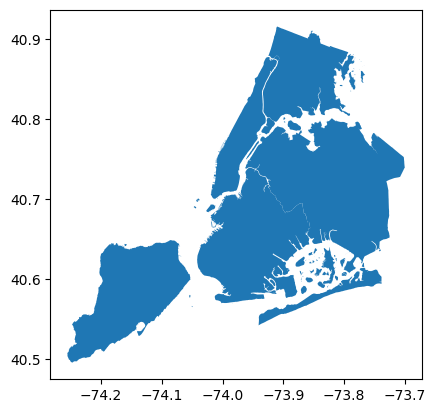

In [78]:
# Load in a GeoJSON
boroughs_gdf = gpd.read_file(Path(DATA_DIRECTORY) / 'Borough Boundaries.geojson')
print(f"The file's original CRS is '{boroughs_gdf.crs}'")

boroughs_gdf.plot()

Once the boroughs are loaded as a `GeoDataFrame` you can use some basic methods and to learn more about the dataset like `.head()` and `.tail()` which preview elements of the data.

In [ ]:
# Let's use head() to look at the first rows — of course, there are only 5 boroughs
boroughs_gdf.head()

,boro_code,boro_name,shape_area,shape_leng,geometry
0,5,Staten Island,1623620725.05,325917.35395,"MULTIPOLYGON (((-74.05051 40.56642, -74.05047 ..."
1,2,Bronx,1187174784.85,463179.772813,"MULTIPOLYGON (((-73.89681 40.79581, -73.89694 ..."
2,4,Queens,3041418505.55,888199.730955,"MULTIPOLYGON (((-73.82645 40.59053, -73.82642 ..."
3,1,Manhattan,636520502.801,357713.30866,"MULTIPOLYGON (((-74.01093 40.68449, -74.01193 ..."
4,3,Brooklyn,1934138258.43,728148.53241,"MULTIPOLYGON (((-73.86327 40.58388, -73.86381 ..."


In [35]:
# And tail() shows the last rows! We can supply an integer argument to specify exactly how many
boroughs_gdf.tail(1)

,boro_code,boro_name,shape_area,shape_leng,geometry
4,3,Brooklyn,1934138258.43,728148.53241,"MULTIPOLYGON (((-73.86327 40.58388, -73.86381 ..."




Note that GeoJSONs are by definition in the WGS84 coordinate reference system, [which is also ESPG: 4326](https://epsg.io/4326). As discussed before, you will most often want to work in more typical units for urban design and architecture, like feet! Converting to [ESPG: 2263](https://epsg.io/2263) allows us to uses a standard projection for the state of New York where units are in feet.

The `.to_crs()` method can either return a new `GeoDataFrame` in the desired projection, or convert an existing one. To do the later, you need to supply the `inplace=True` argument.

In [79]:
# Change the projection with .to_crs() to ESPG 2263
boroughs_gdf.to_crs(2263, inplace=True)
print(f"The file's adjusted CRS is '{boroughs_gdf.crs}' or '{boroughs_gdf.crs.name}'")

The file's adjusted CRS is 'EPSG:2263' or 'NAD83 / New York Long Island (ftUS)'


For simplicity, let's look at just one borough — Manhattan. We can use properties like `.loc()` to retrieve specific cells.

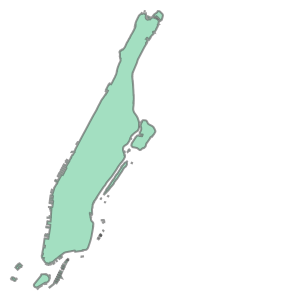

In [126]:
# We can use .loc to find cells by index and name
# This gets the geometry from the fourth row
manhattan_geom = boroughs_gdf.loc[3, 'geometry']
manhattan_geom

A more flexible approach would be to use a filter, matching against the desired borough name.

In [71]:
# This approach looks for the rows that have the right borough name
# In this case, we can be confident that there's only one result
manhattan_geom = boroughs_gdf[boroughs_gdf['boro_name'] == 'Manhattan'].geometry
manhattan_geom

3    MULTIPOLYGON (((981219.056 188655.316, 980940....
Name: geometry, dtype: geometry

### Tax lots

The PLUTO tax lots are large!How many tax lots do you think are in NYC? In the borough of Manhattan?

 The file itself is >100MB. Loading this into the Notebook can take several minutes. There are a few ways to speed this up:

- Read from a Shapefile folder, instead of a ZIP archive.
- Load in just one record using the `rows` argument.
- Filter the area you want to extract by another geometry using `mask`

Loading in just one record is a great way to check a dataset's attribtues for a large Shapefile. But watch out! If you do this using the ZIP archive it will take much longer, as GeoPandas needs to expand and decompress the entire file first.

Let's start by loading in one row first.

In [81]:
# Load in exactly one row of the dataset — this is very fast!
one_lot_gdf = gpd.read_file(Path(DATA_DIRECTORY) / 'nyc_mappluto_23v2_shp', rows=1)
one_lot_gdf

,Borough,Block,Lot,CD,BCT2020,BCTCB2020,CT2010,CB2010,SchoolDist,Council,...,FIRM07_FLA,PFIRM15_FL,Version,DCPEdited,Latitude,Longitude,Notes,Shape_Leng,Shape_Area,geometry
0,MN,1,201,101,1000100,10001001000,1,1000,02,0,...,NaN,1,23v2,NaN,40.698188,-74.041329,NaN,0.0,1.148539e+06,"POLYGON ((973648.066 193711.894, 973525.342 19..."


In [82]:
# This one-row dataset has exactly the same CRS as the full dataset
print(f'The one-row dataset has CRS "{one_lot_gdf.crs.name}": and shape {one_lot_gdf.shape}')

The one-row dataset has CRS "NAD83 / New York Long Island (ftUS)": and shape (1, 95)


In [83]:
# This one-row dataset has exactly the same columns as the full dataset
for c in one_lot_gdf.columns:
    print(f' - {c}')

 - Borough
 - Block
 - Lot
 - CD
 - BCT2020
 - BCTCB2020
 - CT2010
 - CB2010
 - SchoolDist
 - Council
 - ZipCode
 - FireComp
 - PolicePrct
 - HealthCent
 - HealthArea
 - Sanitboro
 - SanitDistr
 - SanitSub
 - Address
 - ZoneDist1
 - ZoneDist2
 - ZoneDist3
 - ZoneDist4
 - Overlay1
 - Overlay2
 - SPDist1
 - SPDist2
 - SPDist3
 - LtdHeight
 - SplitZone
 - BldgClass
 - LandUse
 - Easements
 - OwnerType
 - OwnerName
 - LotArea
 - BldgArea
 - ComArea
 - ResArea
 - OfficeArea
 - RetailArea
 - GarageArea
 - StrgeArea
 - FactryArea
 - OtherArea
 - AreaSource
 - NumBldgs
 - NumFloors
 - UnitsRes
 - UnitsTotal
 - LotFront
 - LotDepth
 - BldgFront
 - BldgDepth
 - Ext
 - ProxCode
 - IrrLotCode
 - LotType
 - BsmtCode
 - AssessLand
 - AssessTot
 - ExemptTot
 - YearBuilt
 - YearAlter1
 - YearAlter2
 - HistDist
 - Landmark
 - BuiltFAR
 - ResidFAR
 - CommFAR
 - FacilFAR
 - BoroCode
 - BBL
 - CondoNo
 - Tract2010
 - XCoord
 - YCoord
 - ZoneMap
 - ZMCode
 - Sanborn
 - TaxMap
 - EDesigNum
 - APPBBL
 - APPD

We only want lots for the borough of Manhattan. We can load in just the relevant lots using the `mask` argument. However, the CRS of the dataset was  "NAD83 / New York Long Island (ftUS)". Thankfully, we've already converted a geometry of Manahttan to that coordinate reference system before.

There are 42181 tax lots in the PLUTO dataset in Manhattan


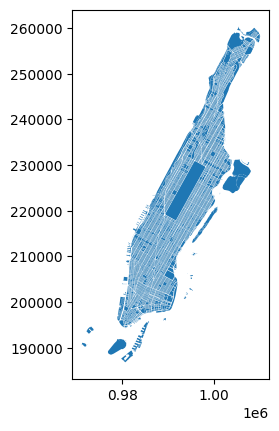

In [85]:
# Note this still takes ~1 minute for me
lots_gdf = gpd.read_file(Path(DATA_DIRECTORY) / 'nyc_mappluto_23v2_shp', mask=manhattan_geom)
lots_gdf.plot()
print(f'There are {len(lots_gdf)} tax lots in the PLUTO dataset in Manhattan')

### Building footprints

Building footprints take even longer. Let's repeat the process by looking at one row first.

In [58]:
# Load in exactly one row of the dataset — this is very fast!
one_building_gdf = gpd.read_file(Path(DATA_DIRECTORY) / 'buildings', rows=1)
one_building_gdf

,base_bbl,bin,cnstrct_yr,doitt_id,feat_code,geomsource,globalid,groundelev,heightroof,date_lstmo,time_lstmo,lststatype,mpluto_bbl,name,shape_area,shape_len,geometry
0,1003060013,1003956.0,1900.0,512541.0,2100.0,Photogramm,{2403088E-77A6-4071-8B5E-D54AFBC720D9},39.0,73.13,2017-08-22,00:00:00.000,Constructed,1003060013,NaN,0.0,0.0,"POLYGON ((-73.99304 40.71761, -73.99301 40.717..."


In [92]:
# This one-row dataset has exactly the same CRS as the full dataset
print(f'The one-row dataset has CRS "{one_building_gdf.crs.name}"')

The one-row dataset has CRS "GCS_WGS84_DD"


Of course, we will want all the buildings from Manhattan to start. We could use the `mask` attribute again.

A faster approach will be to switch `read_file()` to use the `pyogrio` engine. Unfortunately, this only works with `bbox`. This uses a rectangular bounding box — so it will be less precise than `mask`.

We'll need to install `pyogrio` to use it, as it is not included by default in GeoPandas

In [87]:
!pip install pyogrio --quiet

This dataset is back in WGS84 — so we'll need a geometry definition in the same CRS.

In [94]:
manhattan_geom_wgs84 = boroughs_gdf.to_crs(4326).loc[3, 'geometry']

<Axes: >

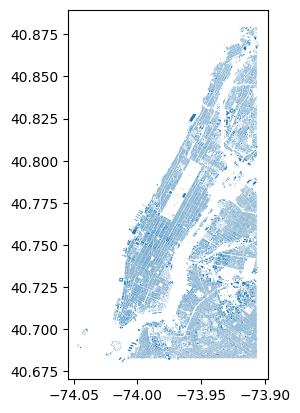

In [97]:
# Loading the entire dataset takes ~30 seconds for me.
buildings_gdf = gpd.read_file(Path(DATA_DIRECTORY) / 'building', bbox=manhattan_geom_wgs84, engine='pyogrio')
buildings_gdf.plot()

## Review and project the data so its suitable for use
After loading the data it's always a good idea to review the size, shape, columns, CRS and other details. When doing this, you should also look at the supporting documentation and data dictionaries.

A nice way to look at quantiative values is `describe()`. This gives summary statistics for each columns

In [101]:
# Summarize a dataset using describe
buildings_gdf.describe()

,bin,cnstrct_yr,doitt_id,heightroof,feat_code,groundelev,shape_area,shape_len
count,1.361590e+05,133683.000000,1.361590e+05,135499.000000,136153.000000,136019.000000,136159.0,136159.0
mean,2.593399e+06,1925.740895,5.316324e+05,48.494509,2259.336849,47.754343,0.0,0.0
std,1.225531e+06,36.323510,3.388749e+05,49.061050,678.708351,30.351105,0.0,0.0
min,1.000002e+06,1719.000000,5.000000e+00,0.000000,0.000000,-16.000000,0.0,0.0
25%,1.063666e+06,1901.000000,2.523445e+05,27.960000,2100.000000,26.000000,0.0,0.0
50%,3.051976e+06,1920.000000,5.043110e+05,38.250000,2100.000000,43.000000,0.0,0.0
75%,3.398388e+06,1931.000000,7.566650e+05,55.180000,2100.000000,62.000000,0.0,0.0
max,4.795023e+06,2023.000000,1.300655e+06,1550.000000,5110.000000,273.000000,0.0,0.0


Of course, you can also plot and explore specific columns!

<Axes: >

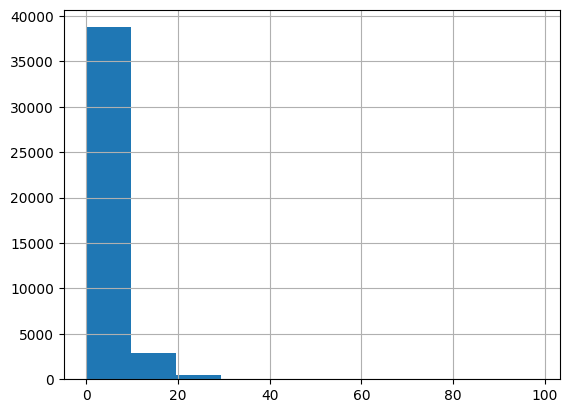

In [113]:
# Let's look at the distribution of floor area ratio (FAR)
lots_gdf['BuiltFAR'].hist()

<Axes: >

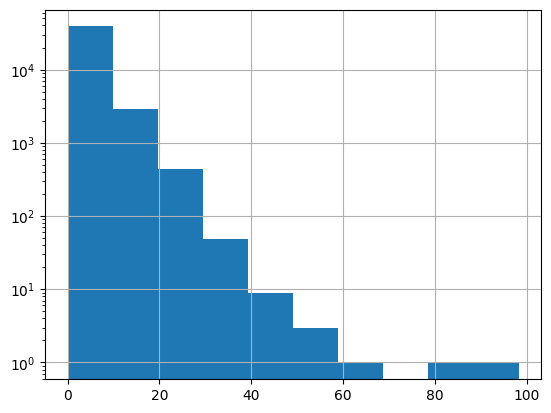

In [114]:
# Using a log scale on the Y-axis can help reveal the long tail
lots_gdf['BuiltFAR'].hist(log=True)

And of course, we can plot the data, using the `column` argument to reveal different attribtues.

<Axes: >

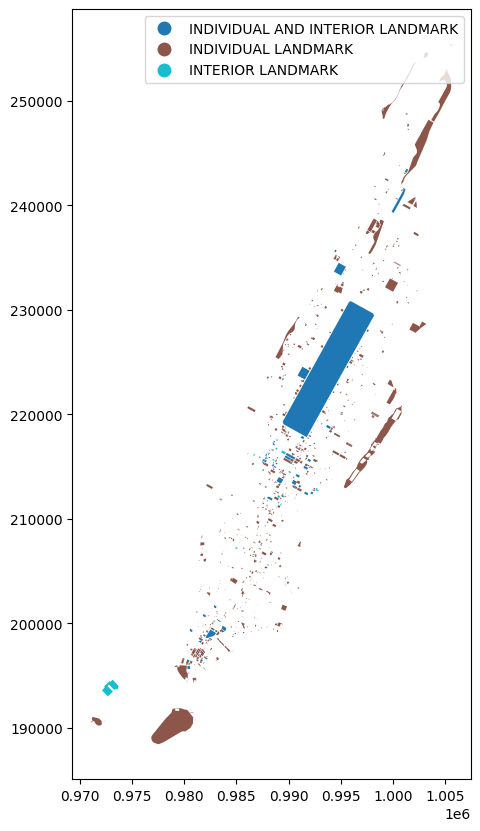

In [122]:
# This can show us all lots with some landmarks in the city
lots_gdf.plot(column='Landmark', figsize=(10, 10), legend=True)

Most importantly, we'll want to be able to do some spatial joins. We need to make sure everything has the same CRS.

In [104]:
# Compare the CRS for all datasets
for df in (boroughs_gdf, lots_gdf, buildings_gdf):
    print(df.crs.name)

NAD83 / New York Long Island (ftUS)
NAD83 / New York Long Island (ftUS)
WGS84(DD)


It looks like the buildings data set is in the WGS 84 CRS. We should covnert it to NAD83.

In [117]:
buildings_gdf.to_crs(2263, inplace=True)

# Now they should all be the same!
for df in (boroughs_gdf, lots_gdf, buildings_gdf):
    print(df.crs.name)

NAD83 / New York Long Island (ftUS)
NAD83 / New York Long Island (ftUS)
NAD83 / New York Long Island (ftUS)


## Filter and join the datasets

With a better understanding of our datasets, we can proceed to join and filter them as we want. As a warm-up, let's start by filtering the buildings (which we got with `bbox`) to only buildings contained in Manhattan.

GeoPandas `clip` is an efficient way to do this. As it sounds, this clips the dataset to the area matching the geometry.

<Axes: >

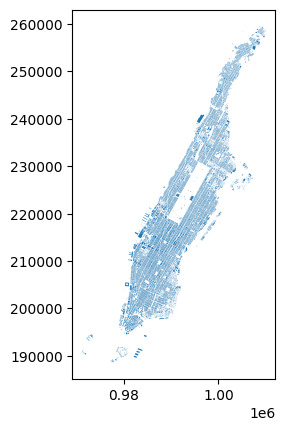

In [135]:
# This takes about ~30 seconds for me
manhattan_buildings_gdf = buildings_gdf.clip(manhattan_geom)
manhattan_buildings_gdf.plot()

Another common operation is a filter. Let's filter our tax lots to publicly-owned lots. From the [PLUTO data dictionary](https://s-media.nyc.gov/agencies/dcp/assets/files/pdf/data-tools/bytes/meta_mappluto_unclipped.pdf), it looks like we can use the `OwnerType` field, with the `C` value indicating public city ownership. Let's take a look!

<Axes: >

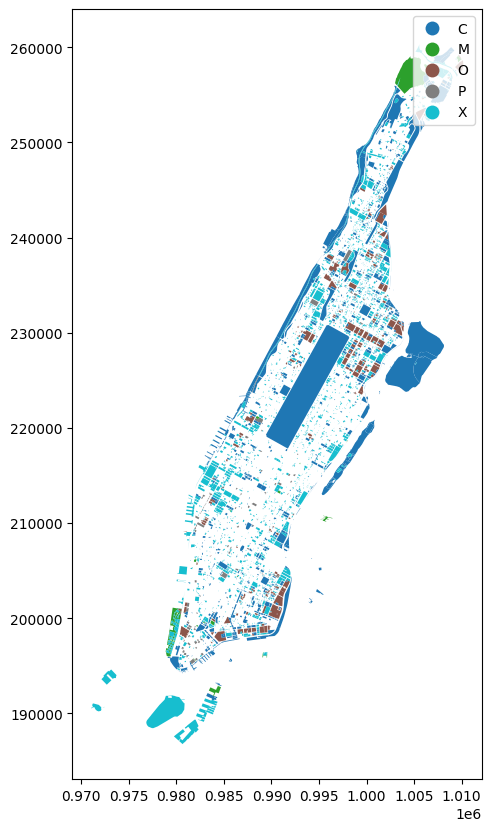

In [140]:
# Plot the lots by owner type categorization
lots_gdf.plot(column='OwnerType', figsize=(10, 10), legend=True)

In [142]:
# Look at the number of lots for each ownership type
lots_gdf['OwnerType'].value_counts()

X    3608
C    1369
O     273
P     130
M      18
Name: OwnerType, dtype: int64

This looks right! Let's filter to public city ownership.

In [145]:
# Use a filter condition
city_lots_gdf = lots_gdf[lots_gdf['OwnerType'] == 'C']
city_lots_gdf.shape

(1369, 95)

If we wanted, we could filter with an AND or OR condition. Let's look at both city-owned and state/federal as well.

In [147]:
# Use a filter condition with an OR condition using |
city_state_federal_lots_gdf = lots_gdf[(lots_gdf['OwnerType'] == 'C') | (lots_gdf['OwnerType'] == 'O')]
city_state_federal_lots_gdf.shape

(1642, 95)

And you can even filter with multiple columns. In this case, let's look at city-owner lots that have any landmark status.

In [163]:
# If a lots is a landmark, it has one of the following three categories
# Non-landmark lots don't have any landmark status!
lots_gdf['Landmark'].value_counts()

INDIVIDUAL LANDMARK                 845
INDIVIDUAL AND INTERIOR LANDMARK     74
INTERIOR LANDMARK                    16
Name: Landmark, dtype: int64

There area 89 city-owned landmarked lots


<Axes: >

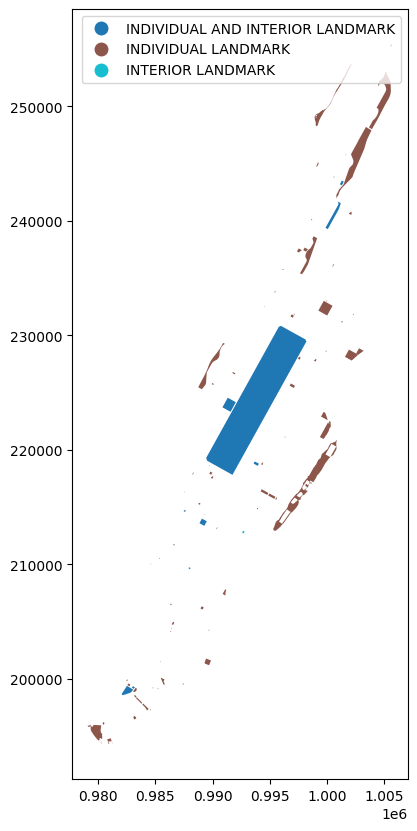

In [176]:
# Use a filter condition with an AND condition using &
# We can use notnull() to find lots that have any landmark status
city_landmark_lots_gdf = lots_gdf[(lots_gdf['OwnerType'] == 'C') & (lots_gdf['Landmark'].notnull())]
print(f'There area {len(city_landmark_lots_gdf)} city-owned landmarked lots')
city_landmark_lots_gdf.plot(column='Landmark', figsize=(10, 10), legend=True)

As our final step, let's do a spatial join to bring in attributes from one dataset to another. As a simple example, let's get the maximum height of any buildings on city-owned and landmarked lots.

`sjoin` will attach all the attributs from one dataset to another, if their geometry overlap. So we can start by attaching all data from buildings to the tax lots they overlap with.

In [211]:
lots_with_buildings_data_gdf = city_landmark_lots_gdf.sjoin(manhattan_buildings_gdf)
print(f'There are {len(lots_with_buildings_data_gdf)} rows in the result')
lots_with_buildings_data_gdf.head()

There are 328 rows in the result


,Borough,Block,Lot,CD,BCT2020,BCTCB2020,CT2010,CB2010,SchoolDist,Council,...,doitt_id,heightroof,feat_code,groundelev,shape_area,shape_len,base_bbl,mpluto_bbl,geomsource,globalid
4,MN,3,1,101,1031900,10319001002,319,1001,02,1,...,255123.0,38.0,2100.0,9.0,0.0,0.0,1000030001,1000030001,Other (Man,{36144537-62C1-4E61-8F9E-92B4738612FF}
4,MN,3,1,101,1031900,10319001002,319,1001,02,1,...,415876.0,11.0,2100.0,11.0,0.0,0.0,1000030001,1000030001,Other (Man,{F01D13A0-1FAB-4AD7-990A-15692454A433}
4,MN,3,1,101,1031900,10319001002,319,1001,02,1,...,1295095.0,10.0,2100.0,10.0,0.0,0.0,1000030001,1000030001,Other (Man,{ECDA0520-CCEE-4302-8521-B1C52D9F02D0}
4,MN,3,1,101,1031900,10319001002,319,1001,02,1,...,1293848.0,20.0,2100.0,10.0,0.0,0.0,1000030001,1000030001,Other (Man,{249ACD2A-5CD8-4C70-8EE6-67D86459C492}
4,MN,3,1,101,1031900,10319001002,319,1001,02,1,...,1295094.0,10.0,2100.0,10.0,0.0,0.0,1000030001,1000030001,Other (Man,{EBB50C86-B1A1-4E5B-BDDC-20DA7563B38D}


But wait! Before, we found 89 lots. How can there now be more than that?

The answer is that a spatial join will attach a repeat lots row for every matching building. So some lots have multiple buildings on them!

To simplify our results, we can do a `groupby`. Essentially, this combines duplicate rows as you want. The simplest way to do this is to only group exactly the values you want. In this case, we want the maximum `heightroof` for each of the unique lots using `Lot`.


In [242]:
lots_with_heights_gdf = lots_with_buildings_data_gdf.groupby(level=0)[['heightroof']].agg({
    'heightroof': 'max'
})
lots_with_heights_gdf.shape

(81, 1)

In [250]:
final_join_gdf = city_landmark_lots_gdf.join(lots_with_heights_gdf)

## Apply functions to the datasets

<Axes: >

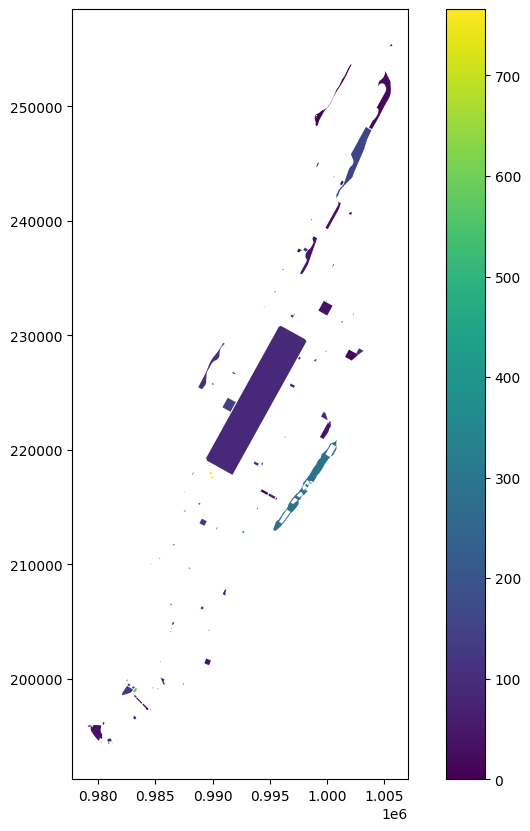

In [253]:
def rename(height):
    if height > 0:
        return height
    return 0

final_join_gdf['heightroof'] = final_join_gdf['heightroof'].apply(rename)
final_join_gdf.plot(column='heightroof', figsize=(10, 10), legend=True)

## Export the results

In [256]:
# Make an empty file and default layer
new_3dm = rhino3dm.File3dm()
new_3dm.Layers.AddLayer("tax_lots", (255, 255, 255, 255))

0

In [259]:
# Add a curve for the outline of the boroughs
for lot in final_join_gdf.explode().geometry:
    polyline_curve = rhino3dm.Polyline(
        [
            rhino3dm.Point3d(x, y, 0)
            for (x, y) in lot.exterior.coords
        ]
    ).ToPolylineCurve()
    new_3dm.Objects.Add(polyline_curve)

<ipython-input-259-17ce7d089823>:2: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  for lot in final_join_gdf.explode().geometry:


In [260]:
# Save the file. Make sure to check the version matches your version of Rhino.
new_3dm.Write("tax_lots.3dm", version=7)

True

In [261]:
final_join_gdf.to_csv('example.csv')